In [1]:
import pandas as pd
import numpy as np
from functools import partial
from scipy.optimize import minimize, Bounds
from scipy.stats import binom, multinomial, norm, multivariate_normal
from sklearn.utils.fixes import logsumexp
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Political Blog Classification

You have already seen this data in class. Your job is simply to build a classifier that learns to classify blogs as "conservative" or "liberal" based on their word usage.

In [87]:
word_count = pd.read_csv('poliblog_wordcount.csv').drop('Unnamed: 0', 1)
ratings = pd.read_csv('poliblog_ratings.csv', usecols=[1])['poliblog.ratings']

X_train, X_test, y_train, y_test = train_test_split(word_count, ratings)

In [88]:
word_count.tail()

,obama,clinton,mccain,said,people,just,like,campaign,democratic,new,...,blow,land,web,spread,essentially,publicly,heavy,heck,hundreds,sounds
768,0,0,0,3,1,1,0,0,3,5,...,0,0,0,0,0,1,0,0,0,0
769,0,0,0,0,1,0,0,2,2,0,...,0,0,1,0,0,0,0,0,0,0
770,3,1,0,1,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
771,2,1,3,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
772,1,4,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
democrat = y_train.index[y_train == 100].tolist()
republican = y_train.index[y_train == -100].tolist()

In [56]:
frequency_democrat = X_train.loc[democrat].sum(axis=0)/X_train.loc[liberal].sum(axis=0).sum()
frequency_republican = X_train.loc[republican].sum(axis=0)/X_train.loc[republican].sum(axis=0).sum()

In [ ]:
y_train.index[y_train[]]

In [ ]:
def get_frequencies(data):
    frequencies = data.sum()/data.sum().sum()
    return frequencies

In [200]:
class MClassifier():
    
    def __init__(self, class_priors = [.5,.5], alpha = 0.00001):
        self.alpha = alpha 
        
        #In this exercise priors are given but they could be estimated and maximized using EM
        self.priors = np.log(class_priors)

    def ml(self, df):
        
        #The maximum likelihood estimator for the multinomial probabilities is just the frequencies of each clas
        self.groups = y_train.unique()
        self.frequencies = [df[y_train == group].sum()/df[y_train == group].sum().sum() for group in self.groups]
        self.frequencies[0][self.frequencies[0] == 0] = self.alpha
        self.frequencies[1][self.frequencies[1] == 0] = self.alpha
        pass

    def predict_proba(self, X_to_predict):
        
        # Log-probabilities/frequencies:
        log_frequencies = [np.log(f) for f in self.frequencies]
        
        # Dot product between log probabilities -> because we are calculating the probability of observing
        # each word X_to_predict times = P_i*N_i + N_j*P_j, since we are using log probabilities
        # and observations are independent.
        #likelihood will contain the probability of obtaining a word for each category P(w|B) times the probability
        # of B = P(w|B)*P(B) which is the probability of observing this. Since we are working with log-probs
        # this is: logP(w|B) + logP(B)
        
        likelihood = [X_to_predict @ log_frequency + pri for log_frequency, pri in zip(log_frequencies, self.priors)]
        #To fully complete Bayes theorem we have to divide by the probability P(w) in general. So we will 
        #substract P(w), in order to calculate this We need to exp our likelihoods and then do the log of the sum
        
        p_w = logsumexp(likelihood)
    
        #Now we can calculate P(B|w) with bayes theorem logP(B|w) = logP(w|B)+logP(B) - logP(w)
        
        probs = likelihood - p_w
        
        return np.exp(probs)

    def predict(self, X):
        
        predictions = []
        
        for _, row in X.iterrows():
            predictions.append(np.argmax(self.predict_proba(row)))
            
        return np.array([self.groups[i] for i in predictions])

In [510]:
ratings[ratings==100].count()/ratings.count()

0.3997412677878396

In [511]:
ratings[ratings==-100].count()/ratings.count()

0.6002587322121604

In [202]:
# see how your algorithm does

c = MClassifier(class_priors = [.6, .4])
c.ml(X_train)

(c.predict(X_test) != y_test).sum()

51

# EM algorithm for Binomial data

You are a run-of-the-mill magician, working the streets to make ends meet. One of your staple tricks relies on having special fake coins, which are biased. 

Unfortunately, something has gone wrong, and you have forgotten which coins are biased in which way (more heads? more tails? You can't remember!). You know that there are 2 types of coins, but you have hundreds. 

You decide to flip each coin 30 times, and record the number of times it comes up heads. Based on this data, you need to determine, which coin is of which type, and estimate the bias of each type, so that you can get back to the streets and make that bread.

In [176]:
coin_flips = pd.read_csv('coins.csv').heads.values

In [177]:
coin_flips 

array([ 7, 12, 13,  8, 16,  8,  9, 16,  8,  7, 10,  8, 10, 15, 10, 11,  8,
        8,  7,  7,  7, 10, 13, 11, 10, 11, 11, 13,  6, 13,  8,  8, 12, 11,
        9,  8, 12,  7, 10, 12,  9,  8,  9, 13, 13,  9,  9, 12,  5, 10, 19,
       20, 23, 19, 20, 19, 21, 18, 17, 17, 16, 22, 20, 14, 18, 19, 22, 14,
       20, 22, 15, 21, 18, 16, 16, 21, 19, 19, 18, 20, 20, 18, 19, 21, 23,
       20, 13, 19, 18, 20, 15, 19, 24, 14, 19, 19, 20, 23, 14, 17, 21, 23,
       15, 19, 14, 23, 19, 18, 15, 19, 21, 25, 22, 19, 18, 16, 23, 22, 13,
       17, 19, 21, 18, 16, 15, 18, 18, 12, 21, 15, 17, 19, 18, 22, 20, 17,
       18, 21, 19, 20, 19, 20, 19, 17, 18, 22, 17, 22, 18, 17, 24, 24, 16,
       21, 13, 16, 18, 18, 17, 20, 18, 16, 16, 14, 17, 17, 19, 22, 17, 21,
       24, 16, 22, 18, 21, 19, 19, 16, 20, 16, 17, 17, 21, 24, 13, 17, 18,
       24, 13, 16, 19, 20, 15, 18, 17, 22, 18, 15, 19, 16, 14, 20, 15, 24,
       21, 20, 20, 19, 22, 17, 23, 16, 18, 21, 17, 19, 18, 19, 20, 16, 18,
       21, 16, 20, 25, 23

In [2]:
def expectation(heads, priors, probs):
    
    #P(x|z,B), probability of obtaining a certain value of heads given one of the types
    pcond_head = np.array([binom.pmf(heads, 30, prob) for prob in probs])
    
    #Now we compute the probability of being from a certain type depending on the prior and the parameters
    #P(z|x,B) = P(x|z,B)*P(z)/P(x)
    probz1 = pcond_head[0]*priors[0]/(pcond_head[0]*priors[0] + pcond_head[1]*priors[1]) #T1
    probz2 = pcond_head[1]*priors[1]/(pcond_head[1]*priors[1] + pcond_head[0]*priors[0]) #T2
    
    return probz1, probz2


    
    

In [189]:
def maximization(heads, probz1, probz2, priors, probs):
    
    
    #We update the priors given the conditional probabilities
    priors[0] = np.mean(probz1)
    priors[1] = np.mean(probz2)
    
    #We update the probability parameter of each type of coin
    probs[0] = (probz1 @ heads) / (30*sum(probz1))
    probs[1] = (probz2 @ heads) / (30*sum(probz2))
    
    return priors, probs
    

In [190]:
def EM(heads, priors, probs):
    dif = 1000
    while dif > 1e-7:
        
        probz1, probz2 = expectation(heads, priors, probs)
        priors, new_probs = maximization(heads, probz1, probz2, priors, probs)
        dif = np.linalg.norm(new_probs - probs)
        probs = new_probs
        
    return probs, priors
    

In [738]:
init_betas = np.array([0.0001, 0.9999])
init_p_z = np.array([0.5, 0.5])

betas, p_z = EM(coin_flips, init_p_z, init_betas)

betas, p_z

(array([0.36115288, 0.63969119]), array([0.266, 0.734]))

In [753]:
def sim(n, p, N):
    p = p + np.random.normal(0,.02,1)
    return np.random.binomial(n, p, N)

n = 30
k = np.concatenate([sim(n, .35, 50), sim(n, .60, 200)])

In [754]:
init_betas = np.array([0.4, 0.6])
init_p_z = np.array([0.5, 0.5])

betas, p_z = EM(k, init_p_z, init_betas)

betas, p_z

(array([0.41542208, 0.61579193]), array([0.33101418, 0.66898582]))

# Simple Binomial updating

Practise visualizing the conjugate posterior updates of a Beta-Binomial model!

https://en.wikipedia.org/wiki/Conjugate_prior

In [ ]:
coin_heads = 20
coin_tails = 15

prior_alpha = 2
prior_beta = 2

alpha = # update alpha parameter of beta distribution 
beta = # update alpha parameter of beta distribution 
sns.distplot(np.random.beta(alpha, beta, size = 10000))

# EM for multinomial

Using your own solution, or mine from the answers branch, revisit the multinomial (naive bayes) text classifier and attempt to perform the same problem in an unsupervised fashion: without the labels, try and recover two clusters using a mixter of multinomials model.

In [79]:
def expectationM(blogs, priors, probs):
    #P(x|z,B), probability of obtaining a certain value of words given one of the types
    pcond_head = np.array([[multinomial.pmf(blog, n = sum(blog), p = prob) for _, blog in blogs.iterrows()] for prob in probs])

    
    pcond_head[0][pcond_head[0] == 0] = 1e-300
    pcond_head[1][pcond_head[1] == 0] = 1e-300

    #Now we compute the probability of being from a certain type depending on the prior and the parameters
    #P(z|x,B) = P(x|z,B)*P(z)/P(x)
    
    
    
    probz1 = pcond_head[0]*priors[0]/(pcond_head[0]*priors[0] + pcond_head[1]*priors[1]) #T1
    probz2 = pcond_head[1]*priors[1]/(pcond_head[1]*priors[1] + pcond_head[0]*priors[0]) #T2
    
  
    #probz1 = np.nan_to_num(probz1)
    #probz2 = np.nan_to_num(probz2)
    
    #probz1 = probz1[~np.isnan(probz1)]
    #probz2 = probz2[~np.isnan(probz2)]
    
    return probz1, probz2



In [83]:
def maximizationM(blogs, probz1, probz2, priors):
    
    probs = [np.zeros(len(blogs.columns)), np.zeros(len(blogs.columns))]
    
    
    #We update the priors given the conditional probabilities
    priors[0] = np.mean(probz1)
    priors[1] = np.mean(probz2)
    
    #We update the probability parameter of each type of coin
    
    
    N = np.sum(blogs, axis = 1)
    blogs_frequencies =  blogs.loc[:, :].div(blogs.sum(axis=1), axis=0)
    
 
    for j in range(len(probs[1])):
        probs[0][j] = (probz1 @ blogs_frequencies.iloc[:, j])/sum(probz1)
    
    for j in range(len(probs[1])):
        probs[1][j] = (probz2 @ blogs_frequencies.iloc[:, j])/sum(probz2)
                
    
    return priors, probs

In [93]:
def EMM(blogs, priors, probs):
    dif = 1000
    while dif > 1e-3:
        
        probz1, probz2 = expectationM(blogs, priors, probs)
        priors, new_probs = maximizationM(blogs, probz1, probz2, priors)
        dif = np.linalg.norm(new_probs[0] - probs[0])
        probs = new_probs
        print(priors)
    return probs, priors

In [308]:
probs = [np.zeros(len(word_count.columns)), np.zeros(len(word_count.columns))]
range(len(probs))

range(0, 2)

In [89]:
_, n= word_count.shape

probs = []
for i in range(2):
    probs1 = np.random.choice(100, n)
    probs1 = probs1/sum(probs1)
    if sum(probs1 != 1):
        remaining = 1 - sum(probs1)
        probs1[0] += remaining
    probs.append(probs1)

sum(probs[0])==1

True

In [90]:
print(sum(probs[0])==1)
print(sum(probs[1])==1)

True
True


In [716]:
A, B = expectationM(word_count, [0.5, 0.5], probs)

In [708]:
blog = word_count.iloc[[1]]
blog = np.array(blog.values.tolist()[0])
multinomial.pmf(blog, n = np.sum(blog), p = probs[1])

0.0

In [707]:
np.sum(blog)

299

In [755]:
np.mean(B)

0.5377950059998902

In [756]:
np.mean(A)

0.4622049940001099

In [757]:
probz1, probz2 = expectationM(word_count, [0.2, 0.8], probs)
maximizationM(word_count, probz1, probz2, [0.2, 0.8])

([0.329612111864556, 0.670387888135444],
 [array([2.32076806e-02, 1.65403697e-02, 1.10016068e-02, ...,
         6.26105660e-05, 2.38636146e-04, 3.28689422e-04]),
  array([0.03927095, 0.02641601, 0.01665618, ..., 0.00074198, 0.00040816,
         0.00033984])])

In [109]:
PROBS, PRIORS = EMM(word_count, [0.5, 0.5], probs)

[0.49724022090950637, 0.5027597790904936]
[0.48826780643383705, 0.511732193566163]
[0.4873234870254682, 0.5126765129745318]
[0.4602983320605599, 0.5397016679394401]
[0.42609889488593294, 0.5739011051140671]
[0.4093840202013797, 0.5906159797986202]
[0.4026334084147236, 0.5973665915852765]
[0.402118960160367, 0.597881039839633]
[0.4029094524334761, 0.5970905475665239]
[0.40247865823850615, 0.5975213417614939]


In [110]:
data1 = np.random.multinomial(20, [0.1, 0.2, 0.3, 0.4], size=100)
data2 = np.random.multinomial(20, [0.45, 0.21, 0.3, 0.04], size=50)

In [111]:
df1 = pd.DataFrame.from_records(data1)
df2 = pd.DataFrame.from_records(data2)
df = pd.concat([df1, df2])
df = df.reset_index()
df = df.drop(columns=['index'])

In [112]:
df.head()

,0,1,2,3
0,3,6,4,7
1,1,4,5,10
2,3,3,5,9
3,2,4,7,7
4,1,3,5,11


In [113]:
probs = [[0.1, 0.1, 0.1, 0.7],
         [0.2, 0.2, 0.2, 0.4]]

In [114]:
EMM(df, [0.5, 0.5], probs)

[0.07724156646794685, 0.9227584335320531]
[0.18205365081879768, 0.8179463491812026]
[0.32743238563426424, 0.6725676143657358]
[0.47996985715024415, 0.5200301428497559]
[0.5973373273678694, 0.4026626726321305]
[0.649566655882691, 0.35043334411730903]
[0.6662502323103762, 0.3337497676896239]
[0.6710744482040928, 0.3289255517959072]
[0.672425155903766, 0.327574844096234]


([array([0.10065052, 0.21248633, 0.29648874, 0.39037442]),
  array([0.43853609, 0.2110017 , 0.30313739, 0.04732482])],
 [0.672425155903766, 0.327574844096234])

# Problems with Wages

In this problem , you will see (simulated) data for "wages" in an industry.
 
We believe that wages come from "high skill" and "low skill" workers, with "high skill" workers earning more. But "skill" is a latent variable that we cannot measure. The only data we have is the wages themselves. 

With this data, estimate the percentage of high skill vs. low skill workers in the industry, and say something about the difference in how they are paid.

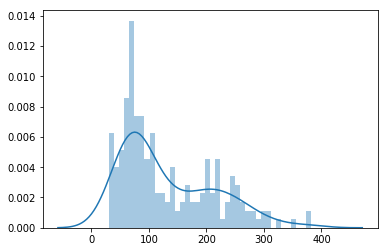

In [6]:
wages = pd.read_csv('wages.csv')
sns.distplot(wages.values, bins=40)

In [132]:
wages

,wage
0,93.787678
1,30.739403
2,34.928079
3,97.399753
4,33.312498
5,46.806906
6,71.045196
7,70.702203
8,31.974941
9,129.599855


In [2]:
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [135]:
kmeans = KMeans(n_clusters=2)

kmeansoutput = kmeans.fit_predict(wages)

wages["KMEANS"] = kmeansoutput

#pl.figure('3 Cluster K-Means')

#pl.scatter(pca_c[:, 0], pca_d[:, 0], c=kmeansoutput.labels_)

#pl.xlabel('Dividend Yield')

#pl.ylabel('Returns')

#pl.title('3 Cluster K-Means')

#pl.show()

In [136]:
wages1 = wages[wages["KMEANS"]==0]
wages2 = wages[wages["KMEANS"]==1]

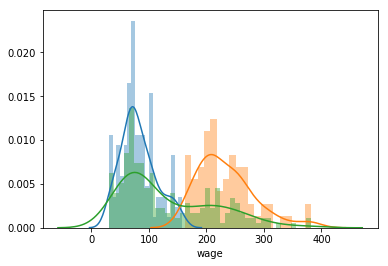

In [137]:
sns.distplot(wages1["wage"], bins = 20)
sns.distplot(wages2["wage"], bins = 20)
sns.distplot(wages["wage"], bins=40)

In [138]:
len(wages1) #real value = 125

134

In [139]:
len(wages2) # real value = 75

66

In [6]:
pca = PCA(n_components=1).fit(wages)
pca_d = pca.transform(wages)

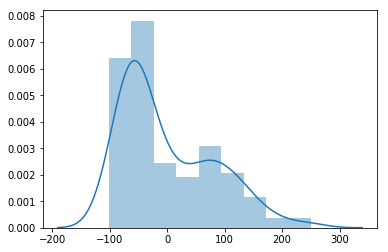

In [8]:
sns.distplot(pca_d)

In [12]:
kmeans = KMeans(n_clusters=2)
kmeansoutput = kmeans.fit_predict(pca_d)
wages["KMEANS"] = kmeansoutput

In [13]:
wages1 = wages[wages["KMEANS"]==0]
wages2 = wages[wages["KMEANS"]==1]

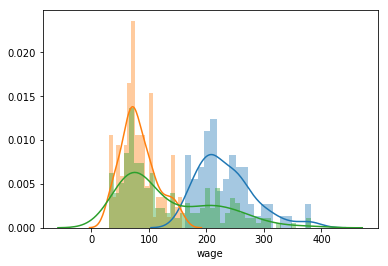

In [14]:
sns.distplot(wages1["wage"], bins = 20)
sns.distplot(wages2["wage"], bins = 20)
sns.distplot(wages["wage"], bins=40)

In [134]:
wages1.mean()

wage      80.795765
KMEANS     0.000000
dtype: float64

In [135]:
wages2.mean()

wage      231.111749
KMEANS      1.000000
dtype: float64

In [2]:
def expectationN(wages, priors, normals):
    
    #P(x|z,B), probability of obtaining a certain value of heads given one of the types
    pcond_head = np.array([norm.pdf(wages, loc = normal[0], scale = normal[1]) for normal in normals])
   

    pcond_head[0][pcond_head[0] == 0] = 1e-300
    pcond_head[1][pcond_head[1] == 0] = 1e-300
    #Now we compute the probability of being from a certain type depending on the prior and the parameters
    #P(z|x,B) = P(x|z,B)*P(z)/P(x)
    probz1 = (pcond_head[0]*priors[0])/(pcond_head[0]*priors[0] + pcond_head[1]*priors[1]) #T1
    probz2 = (pcond_head[1]*priors[1])/(pcond_head[1]*priors[1] + pcond_head[0]*priors[0]) #T2
    
    return probz1, probz2

In [3]:
def maximizationN(wages, probz1, probz2, priors):
    
    normals1 = [[0 , 0], [0, 0]]
    #We update the priors given the conditional probabilities
    priors[0] = np.mean(probz1)
    priors[1] = np.mean(probz2)
    
    #We update the probability parameter of each type of coin
    normals1[0][0] = (probz1 @ wages.iloc[:, 0]) / (sum(probz1))
    normals1[1][0] = (probz2 @ wages.iloc[:, 0]) / (sum(probz2))
    
    normals1[0][1] = np.sqrt((probz1 @ ((wages.iloc[:, 0] - normals1[0][0])**2))/(sum(probz1)))
    normals1[1][1] = np.sqrt((probz2 @ ((wages.iloc[:, 0] - normals1[1][0])**2))/(sum(probz2)))
    
    return priors, normals1

In [4]:
def EMN(wages, priors, normals1):
    dif = 1000
    while dif > 1e-7:
        
        probz1, probz2 = expectationN(wages, priors, normals1)
        priors, new_normals = maximizationN(wages, probz1, probz2, priors)
        dif = np.linalg.norm(np.array(new_normals) - np.array(normals1))
        normals1 = new_normals
        print(priors)
        
    return normals1, priors

In [5]:
normals = [[93, 60],
          [150, 90]]

In [11]:
wages

,wage
0,93.787678
1,30.739403
2,34.928079
3,97.399753
4,33.312498
5,46.806906
6,71.045196
7,70.702203
8,31.974941
9,129.599855


In [333]:
probz1, probz2 = expectationN(wages, [0.5, 0.5], normals)

In [258]:
normals[1][0][0]

array([172.06508604])

In [374]:
a=(wages.iloc[:, 0] - normals[0][0])**2 

In [376]:
probz1@a/sum(probz1)

array([8016.42190516])

In [269]:
np.array(normals[0])

array([[[ 131.90319961]],

       [[6502.96296396]]])

In [335]:
maximizationN(wages, probz1, probz2, [0.5, 0.5], normals)

([0.49999999999998906, 0.500000000000011],
 [[array([131.90319962]), array([6502.96296466])],
  [array([131.90319962]), array([6502.96296466])]])

In [7]:
EMN(wages, [0.1, 0.9], normals)

[0.12308827624286316, 0.8769117237571368]
[0.1563871591681406, 0.8436128408318594]
[0.2197477811004302, 0.7802522188995699]
[0.2964092841769783, 0.7035907158230217]
[0.35872088656907236, 0.6412791134309276]
[0.4016696036736076, 0.5983303963263924]
[0.4318986155707795, 0.5681013844292204]
[0.45425647329809854, 0.5457435267019015]
[0.47123735272757616, 0.5287626472724238]
[0.48429780827677676, 0.5157021917232233]
[0.49442437238596526, 0.5055756276140346]
[0.5023287922060693, 0.4976712077939306]
[0.5085347634013572, 0.4914652365986428]
[0.513431601745599, 0.486568398254401]
[0.5173116587028407, 0.48268834129715943]
[0.5203967293174431, 0.4796032706825569]
[0.5228567018855159, 0.47714329811448425]
[0.5248228220605903, 0.4751771779394096]
[0.5263972360735208, 0.4736027639264792]
[0.5276599466260559, 0.4723400533739443]
[0.5286739486621203, 0.47132605133787986]
[0.5294890675100546, 0.47051093248994535]
[0.5301448592416648, 0.46985514075833523]
[0.5306728243143174, 0.4693271756856827]
[0.5310

([[array([72.08000933]), array([21.86360542])],
  [array([200.14576539]), array([68.09045187])]],
 [0.5328712988662963, 0.46712870113370386])

In [8]:
data1 = np.random.normal(100, 10 , size =100)
data2 = np.random.normal(200, 15, size = 500)

In [9]:
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df = pd.concat([df1, df2])
df = df.reset_index()
df = df.drop(columns=['index'])

In [10]:
EMN(df, [0.5, 0.5], [[100, 20],[200, 10]])

[0.1754148443654844, 0.8245851556345157]
[0.16673816679088035, 0.8332618332091195]
[0.16666621789435546, 0.8333337821056446]
[0.16666618870799377, 0.8333338112920061]
[0.16666618870051061, 0.8333338112994894]


([[array([99.35459071]), array([8.96037389])],
  [array([199.51204329]), array([15.25409284])]],
 [0.16666618870051061, 0.8333338112994894])

# Using SKLEARN

In [134]:
clf = GaussianMixture(n_components=2, verbose =1)
clf.fit(wages)
print(clf.means_)
print(clf.weights_)

Initialization 0
  Iteration 0
Initialization converged: True
[[205.5851049]
 [ 73.123359 ]]
[0.44374955 0.55625045]


In [97]:
clf.var_

AttributeError: 'GaussianMixture' object has no attribute 'var_'

In [128]:
clf.predict(wages)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

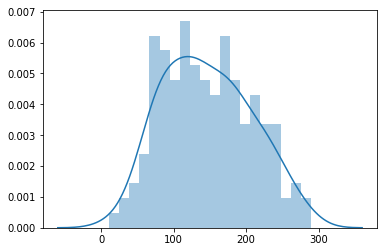

In [125]:
sns.distplot(df, bins = 20)

In [57]:
norm.cdf([0.1, 1, 0, -10, 0],0,100)

array([0.50039894, 0.50398936, 0.5       , 0.46017216, 0.5       ])